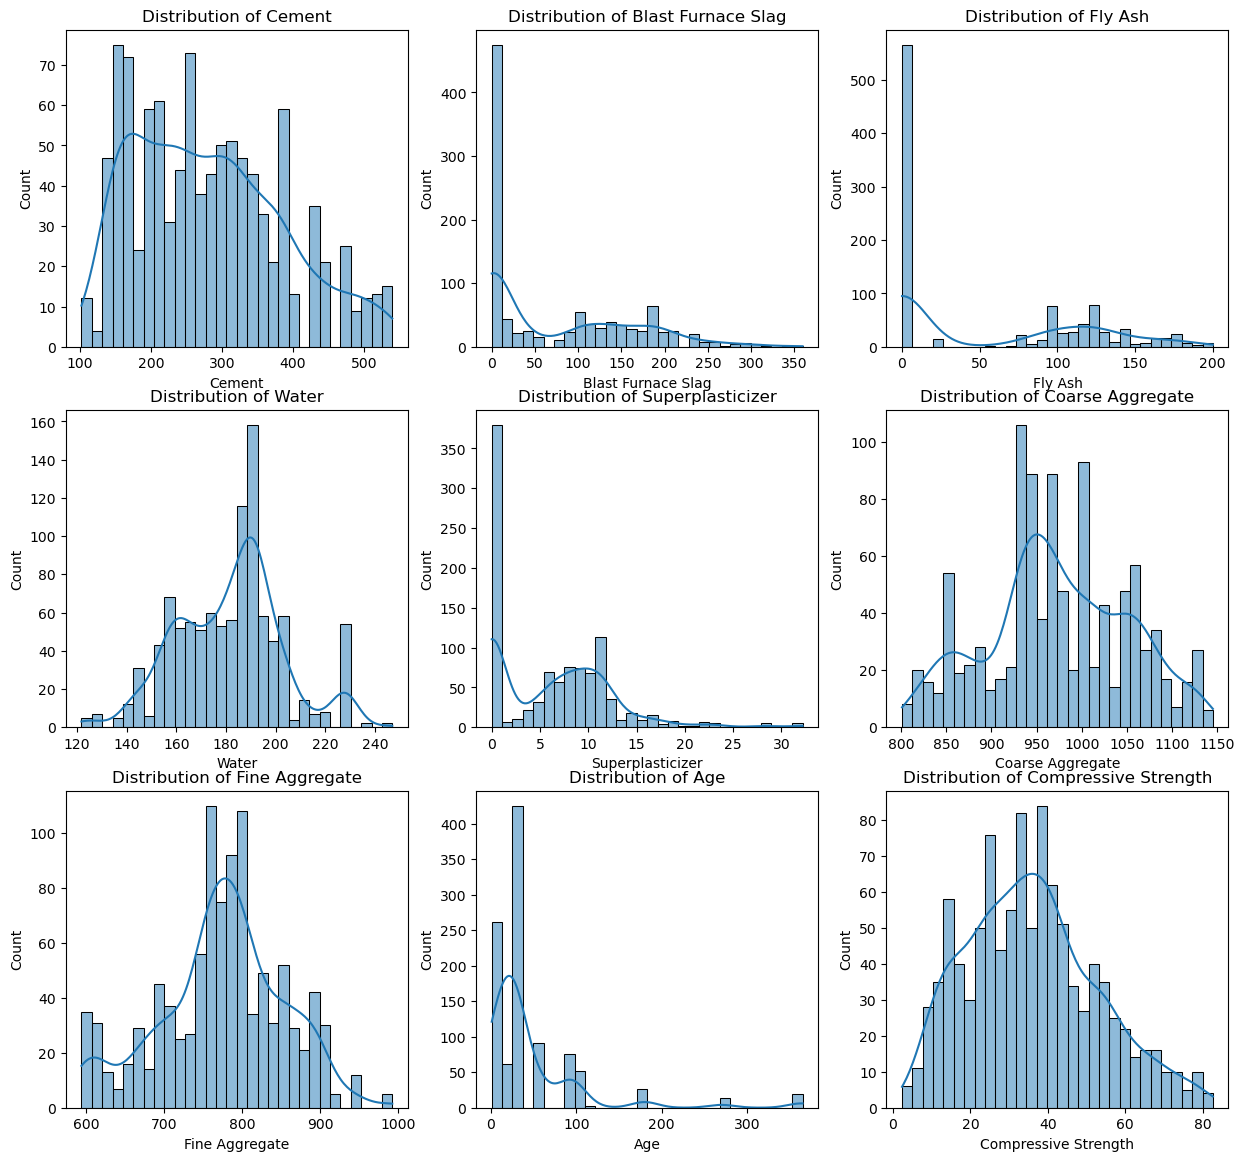

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Visualization of each variable's distribution

# Load the dataset
file_path = "Concrete_Data.csv"
df = pd.read_csv(file_path)

df.columns = [
    "Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer", 
    "Coarse Aggregate", "Fine Aggregate", "Age", "Compressive Strength"
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 14))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    
plt.show()

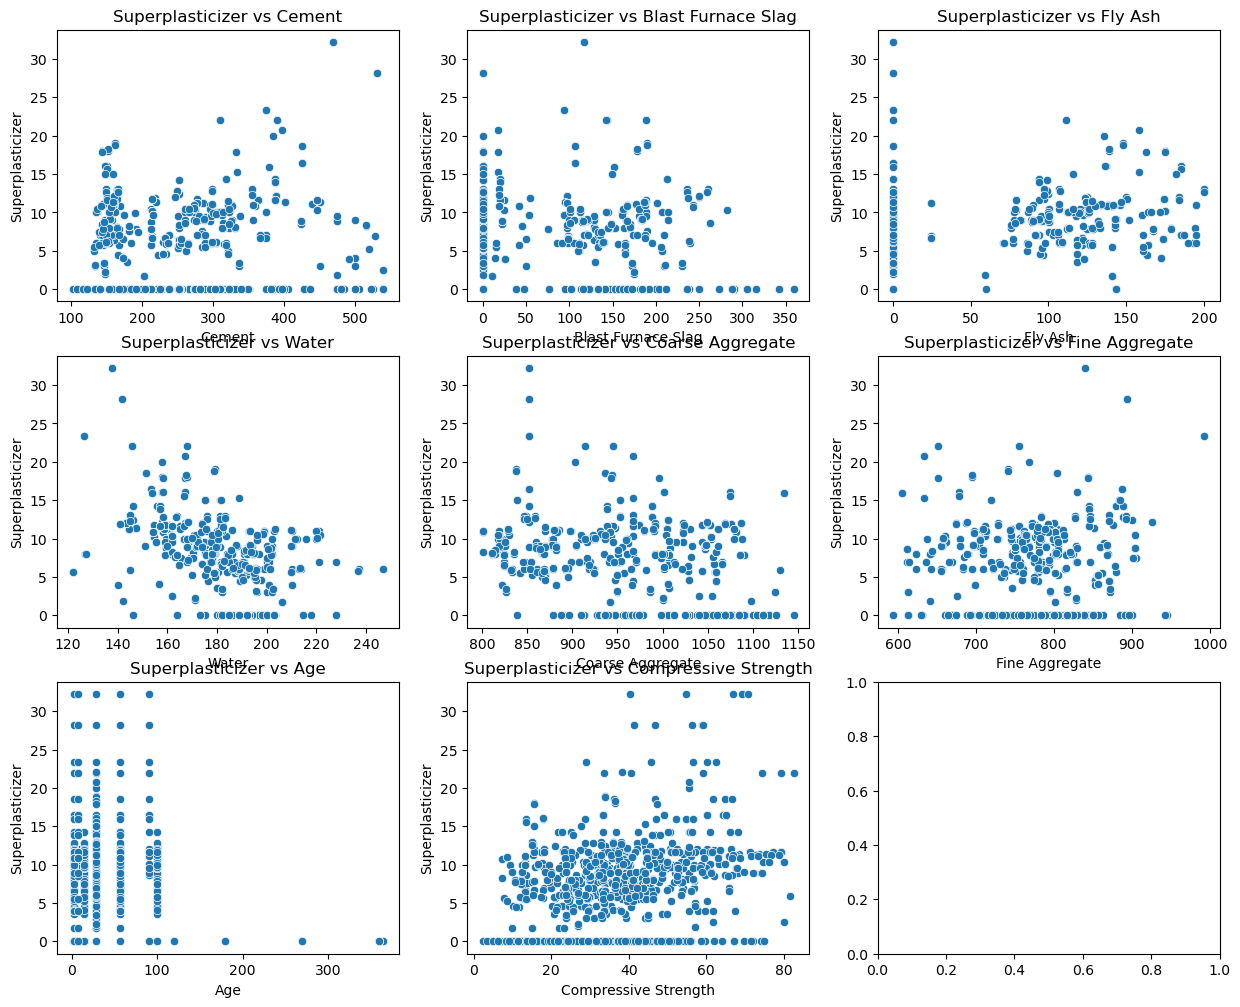

In [2]:
#Visualization of each predictor varaibles' relationship with superplasticizer

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

predictor_var = [col for col in df.columns if col != "Superplasticizer"]

for i, col in enumerate(predictor_var):
    sns.scatterplot(x=df[col], y=df["Superplasticizer"], ax=axes[i])
    axes[i].set_title(f"Superplasticizer vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Superplasticizer")
    
plt.show()

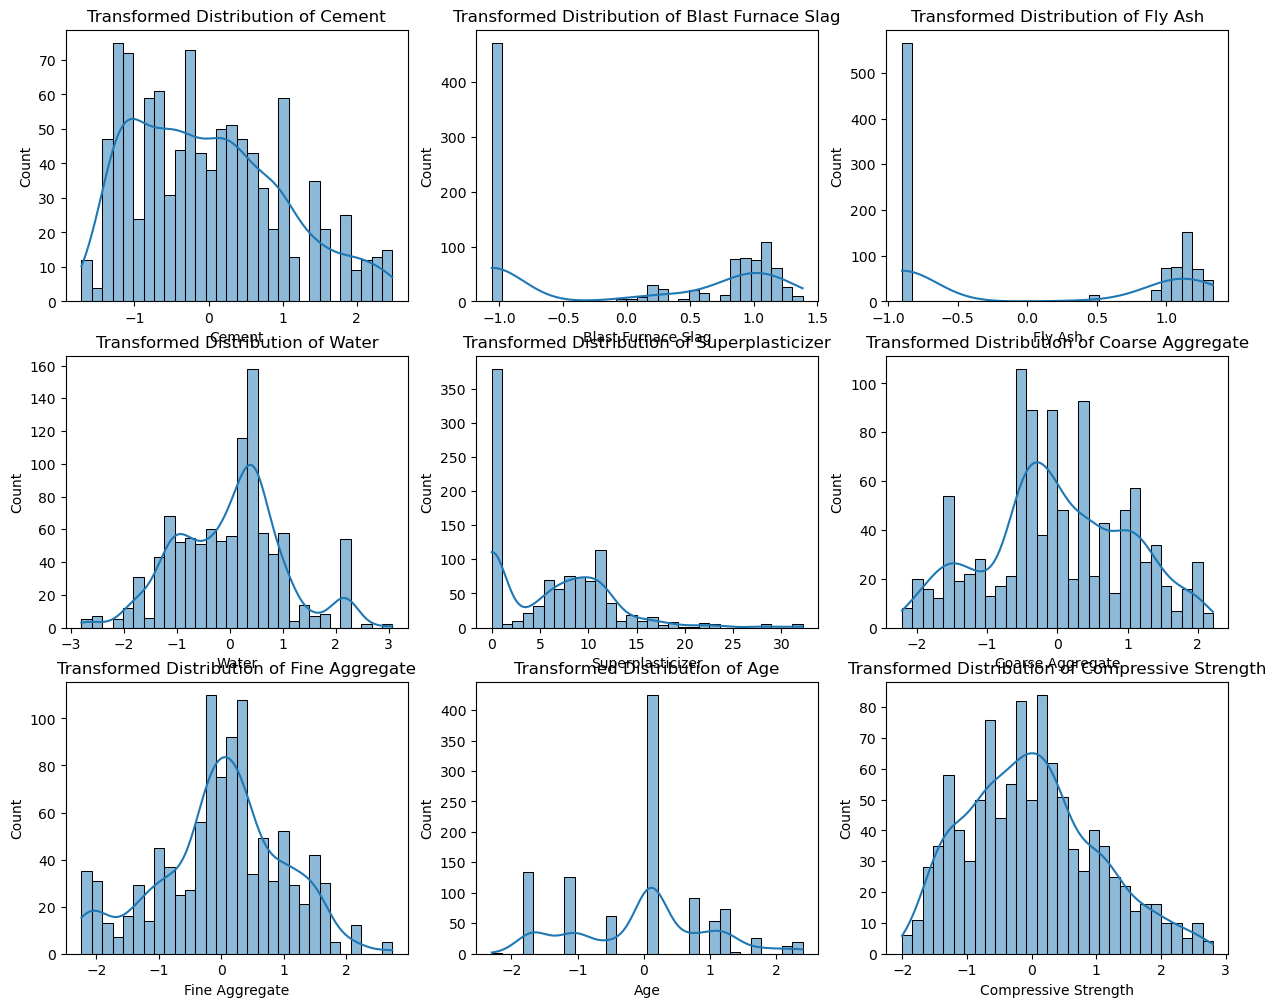

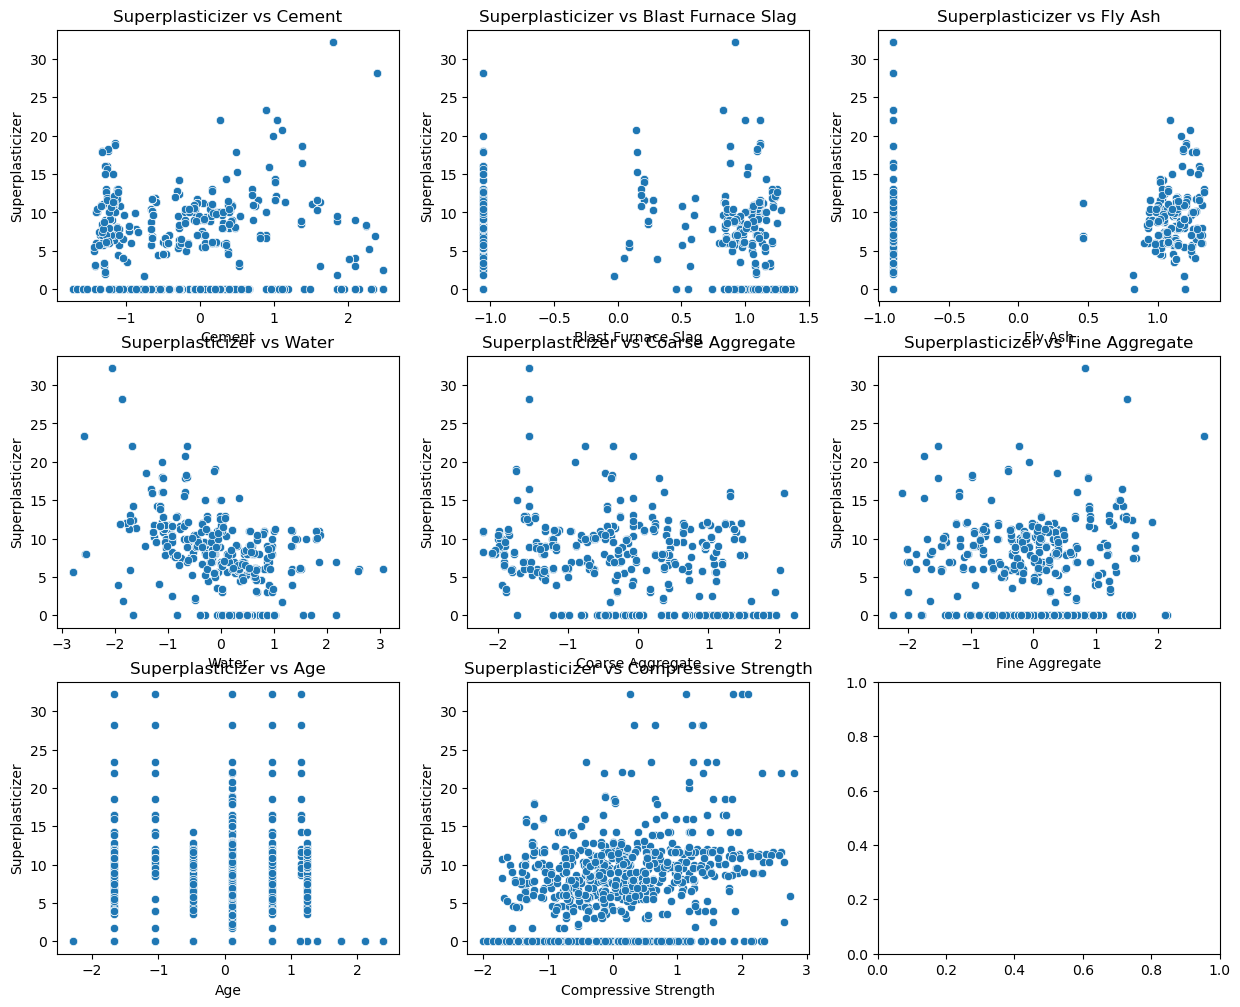

In [3]:
#Pre-processing

from sklearn.preprocessing import StandardScaler
import numpy as np

# Create a copy of the dataset to apply transformations
df_transformed = df.copy()

scaler = StandardScaler()

# Apply transformations
df_transformed["Cement"] = scaler.fit_transform(df[["Cement"]])
df_transformed["Blast Furnace Slag"] = scaler.fit_transform(np.log1p(df[["Blast Furnace Slag"]]))
df_transformed["Fly Ash"] = scaler.fit_transform(np.log1p(df[["Fly Ash"]]))
df_transformed["Water"] = scaler.fit_transform(df[["Water"]])
df_transformed["Coarse Aggregate"] = scaler.fit_transform(df[["Coarse Aggregate"]])
df_transformed["Fine Aggregate"] = scaler.fit_transform(df[["Fine Aggregate"]])
df_transformed["Age"] = scaler.fit_transform(np.log1p(df[["Age"]]))
df_transformed["Compressive Strength"] = scaler.fit_transform(df[["Compressive Strength"]])

#Distributions of pre-processed variables
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df_transformed.columns):
    sns.histplot(df_transformed[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Transformed Distribution of {col}")
    axes[i].set_xlabel(col)
    
plt.show()

#Linear relationship of pre-processed values with superplasticizer
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

predictor_var = [col for col in df_transformed.columns if col != "Superplasticizer"]

for i, col in enumerate(predictor_var):
    sns.scatterplot(x=df_transformed[col], y=df_transformed["Superplasticizer"], ax=axes[i])
    axes[i].set_title(f"Superplasticizer vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Superplasticizer")
    
plt.show()

In [17]:
#UNIVARIATE with STANDARDIZED predictors and RAW response

#Standardize the predictors
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(df.drop(columns=["Compressive Strength"])),
                              columns=df.drop(columns=["Compressive Strength"]).columns,
                              index=df.index)
#Testing and training data
X_train_standardized = pd.concat([X_standardized.iloc[:501], X_standardized.iloc[631:]], axis=0)
X_test_standardized = X_standardized.iloc[501:631]

y_train = pd.concat([df["Compressive Strength"][:501], df["Compressive Strength"][631:]], axis=0).values.reshape(-1, 1)
y_test = df["Compressive Strength"][501:631].values.reshape(-1, 1)

results = {}
predictors = ["Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer",
              "Coarse Aggregate", "Fine Aggregate", "Age"]

# Hyperparameters 
learning_rates = {
    "Cement": 0.1, "Blast Furnace Slag": 0.02, "Fly Ash": 0.02,
    "Water": 0.01, "Superplasticizer": 0.05, "Coarse Aggregate": 0.02,
    "Fine Aggregate": 0.02, "Age": 0.02
} 
iterations = 40000

# Loop over each predictor to train a univariate regression model
for predictor in predictors:
    m = 1  # Initial slope
    b = 1  # Initial intercept
    alpha = learning_rates[predictor]  # Learning rate for slope
    
    # Extract X and y 
    X = X_train_standardized[predictor].values
    y = y_train.ravel()

    n = len(y) 
    
    # Perform gradient descent
    for i in range(iterations):
        y_pred = m * X + b  
        error = y - y_pred  
        
        # Compute gradients
        m_grad = (-2/n) * np.sum(error * X)
        b_grad = (-2/n) * np.sum(error)
        
        # Update parameters
        m -= alpha * m_grad
        b -= alpha * b_grad
        
    # Compute MSE and R-squared
    y_train_pred = m * X_train_standardized[predictor].values + b
    mse = np.mean((y - y_train_pred) ** 2)

    ss_total = np.sum((y - np.mean(y)) ** 2)
    ss_residual = np.sum((y - y_train_pred) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    results[predictor] = {"m": m, "b": b, "MSE": mse, "R-squared": r_squared}


formatted_results = pd.DataFrame(results).T
formatted_results.columns = ["Slope (m)", "Intercept (b)", "MSE", "R-squared (Variance Explained)"]
print(formatted_results)


                    Slope (m)  Intercept (b)         MSE  \
Cement               8.438300      37.214600  203.527354   
Blast Furnace Slag   2.691882      36.901994  270.204129   
Fly Ash             -3.410855      37.149417  265.348821   
Water               -4.394588      36.801690  256.047375   
Superplasticizer     5.272673      36.385645  249.238818   
Coarse Aggregate    -2.133205      36.986196  272.549158   
Fine Aggregate      -2.454477      36.929092  270.792016   
Age                  5.997671      36.935684  243.190535   

                    R-squared (Variance Explained)  
Cement                                    0.265457  
Blast Furnace Slag                        0.024817  
Fly Ash                                   0.042340  
Water                                     0.075909  
Superplasticizer                          0.100482  
Coarse Aggregate                          0.016353  
Fine Aggregate                            0.022695  
Age                                

In [68]:
#UNIVARIATE with RAW predictors and RAW response

X_raw = df.drop(columns=["Compressive Strength"])

X_train = pd.concat([X_raw.iloc[:501], X_raw.iloc[631:]], axis=0)
X_test = X_raw.iloc[501:631]

y_train = pd.concat([df["Compressive Strength"][:501], df["Compressive Strength"][631:]], axis=0).values.reshape(-1, 1)
y_test = df["Compressive Strength"][501:631].values.reshape(-1, 1)

results = {}
predictors = ["Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer",
              "Coarse Aggregate", "Fine Aggregate", "Age"]

# Hyperparameters 
learning_rates = {
    "Cement": 0.0000009, "Blast Furnace Slag": 0.000008, "Fly Ash": 0.0000005,
    "Water": 0.0000008, "Superplasticizer": 0.0000005, "Coarse Aggregate": 0.0000009,
    "Fine Aggregate": 0.0000006, "Age": 0.0000008
} 
iterations = 40000

# Loop over each predictor to train a univariate regression model
for predictor in predictors:
    m = 0  # Initial slope
    b = 0  # Initial intercept
    alpha_m = learning_rates[predictor]
    alpha_b = alpha_m*1000
    
    # Extract X and y 
    X = X_train[predictor].values
    y = y_train.ravel()

    n = len(y) 
    
    # Perform gradient descent
    for i in range(iterations):
        y_pred = m * X + b  
        error = y - y_pred  
        
        # Compute gradients
        m_grad = (-2/n) * np.sum(error * X)
        b_grad = (-2/n) * np.sum(error)
        
        # Update parameters
        m -= alpha_m * m_grad
        b -= alpha_b * b_grad
    
    # Compute MSE and R-squared
    y_train_pred = m * X_train[predictor].values + b
    mse = np.mean((y - y_train_pred) ** 2)

    ss_total = np.sum((y - np.mean(y)) ** 2)
    ss_residual = np.sum((y - y_train_pred) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    results[predictor] = {"m": m, "b": b, "MSE": mse, "R-squared": r_squared}


formatted_results = pd.DataFrame(results).T
formatted_results.columns = ["Slope (m)", "Intercept (b)", "MSE", "R-squared (Variance Explained)"]
print(formatted_results)


                    Slope (m)  Intercept (b)         MSE  \
Cement               0.080789      14.499222  203.527355   
Blast Furnace Slag   0.031215      34.595352  270.204129   
Fly Ash             -0.053323      40.038902  265.348821   
Water               -0.048543      45.326403  268.507526   
Superplasticizer     0.721281      32.056921  250.174764   
Coarse Aggregate     0.013834      23.250926  282.863471   
Fine Aggregate       0.014898      25.073142  284.841462   
Age                  0.094991      32.598183  243.190535   

                    R-squared (Variance Explained)  
Cement                                    0.265457  
Blast Furnace Slag                        0.024817  
Fly Ash                                   0.042340  
Water                                     0.030940  
Superplasticizer                          0.097104  
Coarse Aggregate                         -0.020872  
Fine Aggregate                           -0.028010  
Age                                

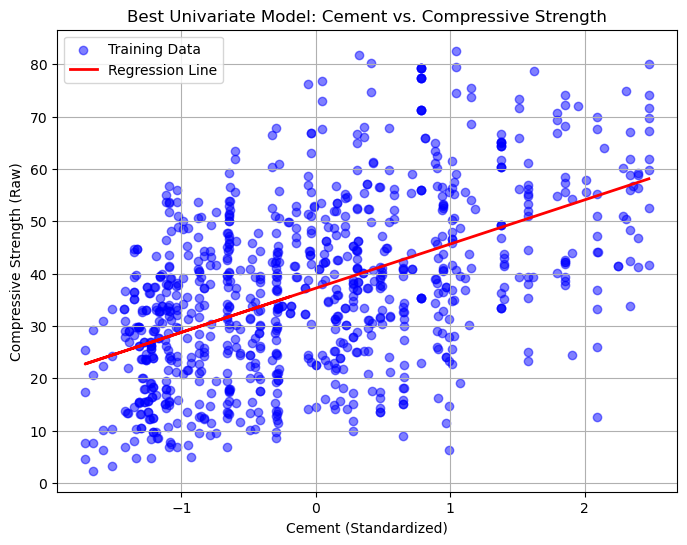

In [73]:
#Visualizing my best model to showcase that the model successfully found the lienar relationship in the training data
#I chose the Cement model (standardized) as it has the highest r squared

m_best = 8.438300  # Slope for Cement model
b_best = 37.214600  # Intercept

# Extract Cement training data (Standardized)
X_train_cement = X_train_standardized["Cement"].values
y_train_cement = y_train.ravel()

y_pred_cement = m_best * X_train_cement + b_best


# Plot the training data
plt.figure(figsize=(8, 6))
plt.scatter(X_train_cement, y_train_cement, color='blue', alpha=0.5, label="Training Data")
plt.plot(X_train_cement, y_pred_cement, color='red', linewidth=2, label="Regression Line")
plt.xlabel("Cement (Standardized)")
plt.ylabel("Compressive Strength (Raw)")
plt.title("Best Univariate Model: Cement vs. Compressive Strength")
plt.legend()
plt.grid()
plt.show()

Testing MSE: 268.103305
Testing Variance Explained (R²): -0.231305


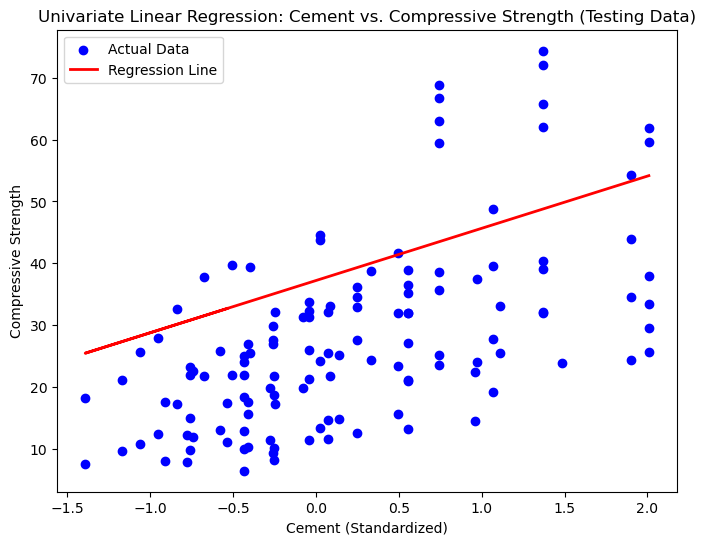

In [74]:
#Testing data evaluation and visualizing my best model
m_best = 8.438300 
b_best = 37.214600 

# Extract Cement testing data (Standardized)
X_test_cement = X_test_standardized["Cement"].values
y_test_cement = y_test.ravel()

y_test_pred = m_best * X_test_cement + b_best

# Compute MSE
mse_test = np.mean((y_test_cement - y_test_pred) ** 2)

# Compute Variance Explained (R-squared)
ss_total = np.sum((y_test_cement - np.mean(y_test_cement)) ** 2)
ss_residual = np.sum((y_test_cement - y_test_pred) ** 2)
r_squared_test = 1 - (ss_residual / ss_total)

print(f"Testing MSE: {mse_test:.6f}")
print(f"Testing Variance Explained (R²): {r_squared_test:.6f}")

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test_cement, y_test_cement, color="blue", label="Actual Data")
plt.plot(X_test_cement, y_test_pred, color="red", label="Regression Line", linewidth=2)
plt.xlabel("Cement (Standardized)")
plt.ylabel("Compressive Strength")
plt.title("Univariate Linear Regression: Cement vs. Compressive Strength (Testing Data)")
plt.legend()
plt.show()

In [87]:
#Multivariate Linear Models
#Update gradient descent algorithm to optimize multivariate linear regression models

X = np.array([
    [3, 4, 4],  
    [4, 2, 1],  
    [10, 2, 5], 
    [3, 4, 5],  
    [11, 1, 1]  
]) 

y = np.array([3, 2, 8, 4, 5])

#X = np.array([3,4,5])
#y = np.array([4])

m = np.array([1.0, 1.0, 1.0])  # m1, m2, m3
b = 1.0
alpha = 0.1  

N = len(y) 

# Compute predictions
y_pred = np.dot(X, m) + b  # Predicted values

error = y - y_pred

# Compute gradients
m_grad = (-2/N) * np.dot(error, X)
b_grad = (-2/N) * np.sum(error)

# Update parameters
m_new = m - alpha * m_grad
b_new = b - alpha * b_grad

print(f"New m_1: {m_new[0]:.6f}")
print(f"New m_2: {m_new[1]:.6f}")
print(f"New m_3: {m_new[2]:.6f}")
print(f"New b: {b_new:.6f}")

New m_1: -10.080000
New m_2: -3.520000
New m_3: -4.840000
New b: -0.720000


In [102]:
#Using gradient descent code, I am optimizing a multivariate linear regression mdoel that uses all 8 predictor variables
#Using standardized values for predictors and raw values for response variable

# Standardize predictors
scaler = StandardScaler()
X_standardized = scaler.fit_transform(df.drop(columns=["Compressive Strength"])) 
y_raw = df["Compressive Strength"].values.reshape(-1, 1) 

# Split into training and testing sets
X_train = np.vstack([X_standardized[:501], X_standardized[631:]])
X_test = X_standardized[501:631]

y_train = np.vstack([y_raw[:501], y_raw[631:]])
y_test = y_raw[501:631]

m = np.ones(X_train.shape[1])
b = 1.0

alpha_m = 0.01 
alpha_b = 0.1 
iterations = 20000

N = len(y_train)

# Gradient Descent
for i in range(iterations):
    y_pred = np.dot(X_train, m) + b 
    error = y_train.ravel() - y_pred.ravel()

    m_grad = (-2/N) * np.dot(X_train.T, error) 
    b_grad = (-2/N) * np.sum(error)  

    m -= alpha_m * m_grad
    b -= alpha_b * b_grad

# Compute MSE and R-squared
y_train_pred = np.dot(X_train, m) + b
mse_train = np.mean((y_train.ravel() - y_train_pred) ** 2)

ss_total = np.sum((y_train.ravel() - np.mean(y_train.ravel())) ** 2)
ss_residual = np.sum((y_train.ravel() - y_train_pred) ** 2)
r_squared_train = 1 - (ss_residual / ss_total)

# Display results
print(f"m: {m}")
print(f"b: {b:.6f}")
print(f"Training MSE: {mse_train:.6f}")
print(f"Training Variance Explained (R²): {r_squared_train:.6f}")

m: [13.8763487  10.7830731   6.8276024  -2.84169806  0.69370691  2.22516989
  2.7313242   7.49862625]
b: 36.535637
Training MSE: 104.154464
Training Variance Explained (R²): 0.624100



Testing Data Evaluation:
Testing MSE: 141.257736
Testing Variance Explained (R²): 0.351253


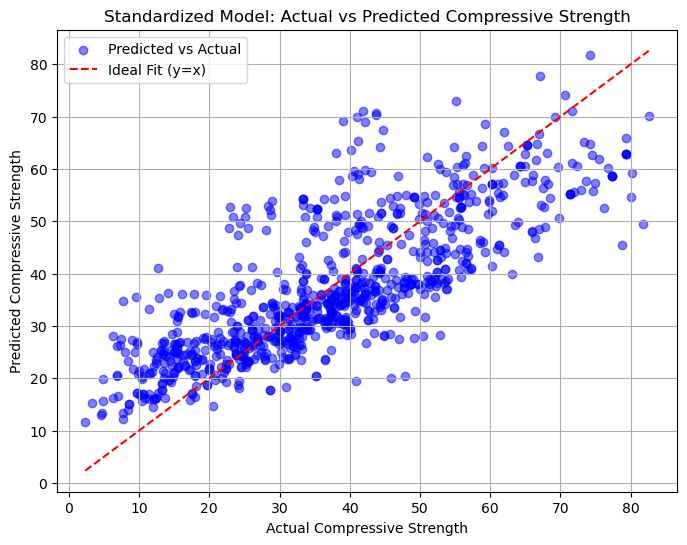

In [104]:
#Visualizing my best model to show that it found the linear relationship in the training data between predictors and response

#I chose the standardized model as it has the highest r squared

plt.figure(figsize=(8, 6))
plt.scatter(y_train.ravel(), y_train_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label="Ideal Fit (y=x)")
plt.xlabel("Actual Compressive Strength")
plt.ylabel("Predicted Compressive Strength")
plt.title("Standardized Model: Actual vs Predicted Compressive Strength")
plt.legend()
plt.grid(True)

plt.show()


Testing Data Evaluation:
Testing MSE: 141.257736
Testing Variance Explained (R²): 0.351253


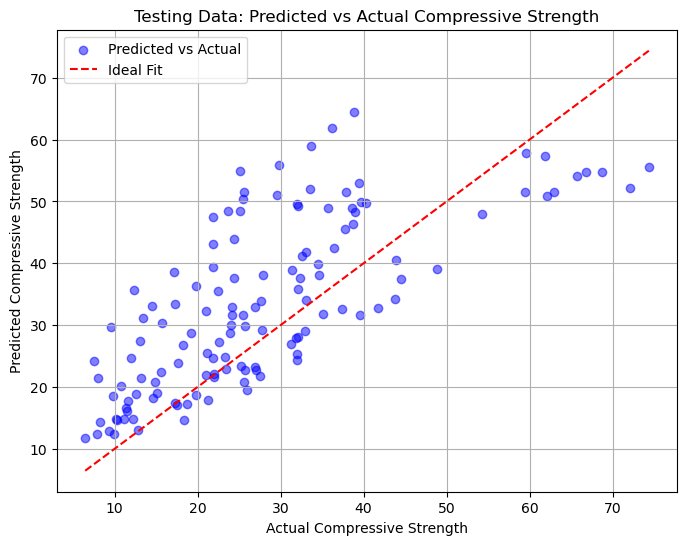

In [106]:
#Testing data evaluation and visualizing on testing data

# testing set
y_test_pred = np.dot(X_test, m) + b

# Compute Mean Squared Error
mse_test = np.mean((y_test.ravel() - y_test_pred) ** 2)

# Compute Variance Explained
ss_total_test = np.sum((y_test.ravel() - np.mean(y_test.ravel())) ** 2)
ss_residual_test = np.sum((y_test.ravel() - y_test_pred) ** 2)
r_squared_test = 1 - (ss_residual_test / ss_total_test)

print("\nTesting Data Evaluation:")
print(f"Testing MSE: {mse_test:.6f}")
print(f"Testing Variance Explained (R²): {r_squared_test:.6f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit")
plt.xlabel("Actual Compressive Strength")
plt.ylabel("Predicted Compressive Strength")
plt.title("Testing Data: Predicted vs Actual Compressive Strength")
plt.legend()
plt.grid(True)
plt.show()

In [107]:
##Using gradient descent code, I am optimizing a multivariate linear regression mdoel that uses all 8 predictor variables
#Using raw values for predictors and raw values for response variable

X_raw = df.drop(columns=["Compressive Strength"]).values
y_raw = df["Compressive Strength"].values.reshape(-1, 1) 

# Split into training and testing sets
X_train = np.vstack([X_raw[:501], X_raw[631:]])
X_test = X_raw[501:631]

y_train = np.vstack([y_raw[:501], y_raw[631:]])
y_test = y_raw[501:631]

m = np.ones(X_train.shape[1])
b = 1.0

alpha_m = 1e-8 
alpha_b = 1e-3
iterations = 40000

N = len(y_train)

# Gradient Descent
for i in range(iterations):
    y_pred = np.dot(X_train, m) + b 
    error = y_train.ravel() - y_pred.ravel()

    m_grad = (-2/N) * np.dot(X_train.T, error) 
    b_grad = (-2/N) * np.sum(error)  

    m -= alpha_m * m_grad
    b -= alpha_b * b_grad

# Compute MSE and R-squared
y_train_pred = np.dot(X_train, m) + b
mse_train = np.mean((y_train.ravel() - y_train_pred) ** 2)

ss_total = np.sum((y_train.ravel() - np.mean(y_train.ravel())) ** 2)
ss_residual = np.sum((y_train.ravel() - y_train_pred) ** 2)
r_squared_train = 1 - (ss_residual / ss_total)

# Display results
print(f"m: {m}")
print(f"b: {b:.6f}")
print(f"Training MSE: {mse_train:.6f}")
print(f"Training Variance Explained (R²): {r_squared_train:.6f}")


m: [0.23033779 0.21819548 0.34262915 0.40734111 0.94467603 0.02321039
 0.07056459 0.15230108]
b: -227.189148
Training MSE: 273.462079
Training Variance Explained (R²): 0.013058


                             OLS Regression Results                             
Dep. Variable:     Compressive Strength   R-squared:                       0.624
Model:                              OLS   Adj. R-squared:                  0.621
Method:                   Least Squares   F-statistic:                     184.9
Date:                  Fri, 28 Feb 2025   Prob (F-statistic):          1.80e-183
Time:                          17:31:29   Log-Likelihood:                -3367.7
No. Observations:                   900   AIC:                             6753.
Df Residuals:                       891   BIC:                             6797.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

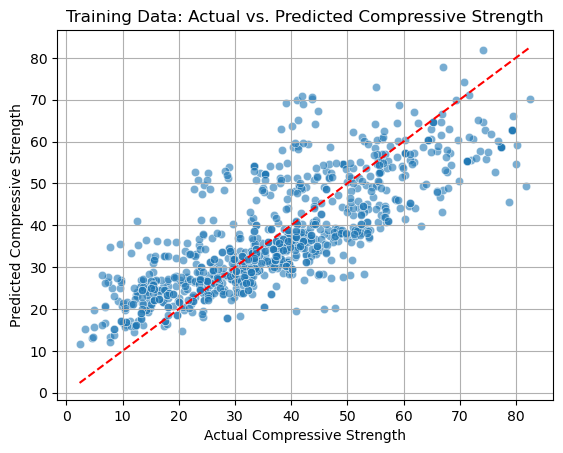

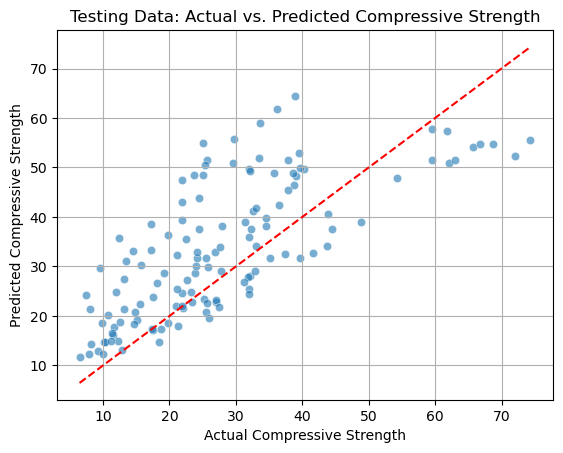

In [8]:
#Testing performance and comparing models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
file_path = "Concrete_Data.csv"
df = pd.read_csv(file_path)

df.columns = [
    "Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer", 
    "Coarse Aggregate", "Fine Aggregate", "Age", "Compressive Strength"
]

X_raw = df.drop(columns=["Compressive Strength"])
y_raw = df["Compressive Strength"]

X_train = pd.concat([X_raw.iloc[:501], X_raw.iloc[631:]], axis=0)
X_test = X_raw.iloc[501:631]

y_train = pd.concat([y_raw.iloc[:501], y_raw.iloc[631:]], axis=0)
y_test = y_raw.iloc[501:631]

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()
print(model.summary())

r_squared_train = model.rsquared
print(f"\nTraining Variance Explained (R²): {r_squared_train:.6f}")

y_test_pred = model.predict(X_test)

# Compute R-squared for testing data
ss_total_test = np.sum((y_test - np.mean(y_test)) ** 2)
ss_residual_test = np.sum((y_test - y_test_pred) ** 2)
r_squared_test = 1 - (ss_residual_test / ss_total_test)

print(f"Testing Variance Explained (R²): {r_squared_test:.6f}")

# Visualizing the model fit on training data
y_train_pred = model.predict(X_train)
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', linestyle="--") 
plt.xlabel("Actual Compressive Strength")
plt.ylabel("Predicted Compressive Strength")
plt.title("Training Data: Actual vs. Predicted Compressive Strength")
plt.grid(True)
plt.show()

#Visualizing the model fit on testing data
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle="--")  # Reference line
plt.xlabel("Actual Compressive Strength")
plt.ylabel("Predicted Compressive Strength")
plt.title("Testing Data: Actual vs. Predicted Compressive Strength")
plt.grid(True)
plt.show()

In [9]:
#Regression analysis
p_values = model.pvalues

print("P-values for each predictor variable:\n")
print(p_values)

P-values for each predictor variable:

const                 7.081965e-02
Cement                6.970969e-41
Blast Furnace Slag    4.145190e-26
Fly Ash               1.894571e-13
Water                 1.918418e-03
Superplasticizer      2.461117e-01
Coarse Aggregate      5.443241e-03
Fine Aggregate        2.738122e-03
Age                   9.516219e-74
dtype: float64


                             OLS Regression Results                             
Dep. Variable:     Compressive Strength   R-squared:                       0.824
Model:                              OLS   Adj. R-squared:                  0.823
Method:                   Least Squares   F-statistic:                     522.2
Date:                  Mon, 03 Mar 2025   Prob (F-statistic):               0.00
Time:                          17:47:31   Log-Likelihood:                -3025.6
No. Observations:                   900   AIC:                             6069.
Df Residuals:                       891   BIC:                             6113.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

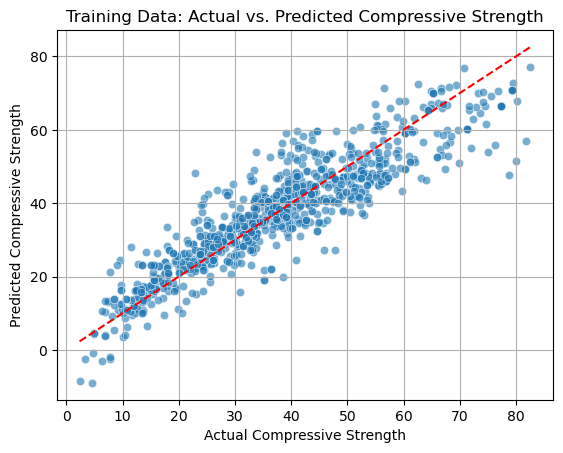

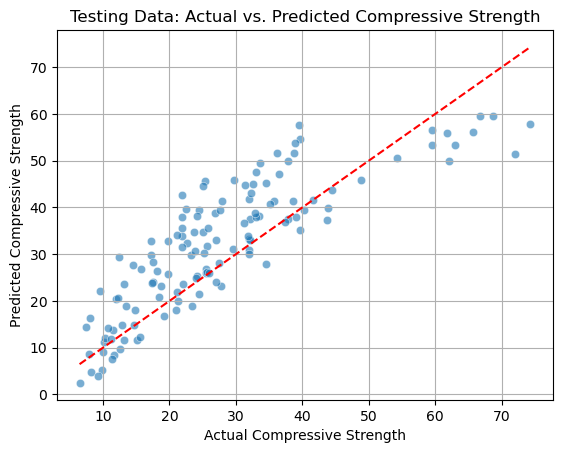

In [6]:
#Pre-processing input features. Explored methods until I found one that makes 1+ input features more significant
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
file_path = "Concrete_Data.csv"
df = pd.read_csv(file_path)

df.columns = [
    "Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer", 
    "Coarse Aggregate", "Fine Aggregate", "Age", "Compressive Strength"
]

X_raw = df.drop(columns=["Compressive Strength"])
y_raw = df["Compressive Strength"]

log_features = ["Cement", "Age", "Water", "Superplasticizer"]
X_log = df.drop(columns=["Compressive Strength"]).copy()
X_log[log_features] = np.log1p(X_log[log_features])

# Split into training and testing sets
X_train = pd.concat([X_log.iloc[:501], X_log.iloc[631:]], axis=0)
X_test = X_log.iloc[501:631]

y_train = pd.concat([y_raw.iloc[:501], y_raw.iloc[631:]], axis=0)
y_test = y_raw.iloc[501:631]

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Compute R-squared for testing data
y_test_pred = model.predict(X_test)
ss_total_test = np.sum((y_test - np.mean(y_test)) ** 2)
ss_residual_test = np.sum((y_test - y_test_pred) ** 2)
r_squared_test = 1 - (ss_residual_test / ss_total_test)

# Print results
print(f"\nTraining Variance Explained (R²): {model.rsquared:.6f}")
print(f"Testing Variance Explained (R²): {r_squared_test:.6f}")

p_values = model.pvalues

print("P-values for each predictor variable:\n")
print(p_values)

# Visualizing the model fit on training data
y_train_pred = model.predict(X_train)
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', linestyle="--") 
plt.xlabel("Actual Compressive Strength")
plt.ylabel("Predicted Compressive Strength")
plt.title("Training Data: Actual vs. Predicted Compressive Strength")
plt.grid(True)
plt.show()

#Visualizing the model fit on testing data
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle="--")  # Reference line
plt.xlabel("Actual Compressive Strength")
plt.ylabel("Predicted Compressive Strength")
plt.title("Testing Data: Actual vs. Predicted Compressive Strength")
plt.grid(True)
plt.show()